# RADIODIFUSIÓN SONORA Y TELEVISIVA
## ISDB-T
### Profesor: De Césare, Pablo
### Alumno: Aaron Stafuza

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from scipy import signal

### Mapeo

Para que la potencia media de todos los sımbolos OFDM sea 1, sea cual sea el esquema de modulacion utilizado, se realiza una normalizacion sobre cada una de las constelaciones, según la siguiente tabla:

<img src=".\Tabla_3.7_Factor_de_normalizacion.png" width="500" height="250">

En la siguiente simulación se estudian los tres modos del sistema ISDB-Tb y además se considera que los únicos esquemas de modulación utilizados son QPSK, 16QAM y 64QAM.

Empiezo armando la constelación de 16QAM basandome en el Codigo Gray. Como podemos ver tenemos para cada valor de dicho código su respectiva posicion en la constelación. 

In [4]:
kmod=1/np.sqrt(10)
mapping_table = {
    (0,0,0,0) : (-3-3j)*kmod,
    (0,0,0,1) : (-3-1j)*kmod,
    (0,0,1,0) : (-3+3j)*kmod,
    (0,0,1,1) : (-3+1j)*kmod,
    (0,1,0,0) : (-1-3j)*kmod,
    (0,1,0,1) : (-1-1j)*kmod,
    (0,1,1,0) : (-1+3j)*kmod,
    (0,1,1,1) : (-1+1j)*kmod,
    (1,0,0,0) :  (3-3j)*kmod,
    (1,0,0,1) :  (3-1j)*kmod,
    (1,0,1,0) :  (3+3j)*kmod,
    (1,0,1,1) :  (3+1j)*kmod,
    (1,1,0,0) :  (1-3j)*kmod,
    (1,1,0,1) :  (1-1j)*kmod,
    (1,1,1,0) :  (1+3j)*kmod,
    (1,1,1,1) :  (1+1j)*kmod
}

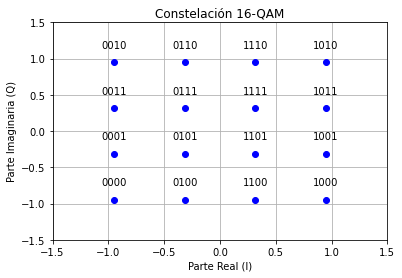

In [5]:
for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b3, b2, b1, b0)
                Q = mapping_table[B]
                plt.plot(Q.real, Q.imag, 'bo')
                plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')
plt.grid(True)
plt.xlim((-1.5, 1.5)); plt.ylim((-1.5,1.5)); plt.xlabel('Parte Real (I)'); plt.ylabel('Parte Imaginaria (Q)')
plt.title('Constelación 16-QAM');

Podmeos observar la constelación que se obtuvo, como dijimos anteriormnete, en código Gray. Con esta técnica se minimizan los errores de bit si un símbolo de la constelación se detecta de forma errónea, además es más probable que los errores sean aislados siendo el proximo bit al erroneo sea detectadamente correctamente.

In [6]:
demapping_table = {v : k for k, v in mapping_table.items()}

demapping_table lo que hace es quitar los 4 valores de 1 bit, que fueron mapeados anteriormente.

## Simulación de los 3 Modos de ISDB-T

Empezamos mostrando la simulación de los tres modos. 

Vemos que tenemos una frecuencia de muestreo de la IFFT, que la calculamos en el PowerPoint. Y ponemos los siguientes valores, ts y el valor de la piloto. Y así para los dos modos restantes.

Vamos a tener diferentes tipos de portadoras:
- dataCarrier: portadora que transmite datos.
- pilotCarrier: portadora piloto, que se utiliza a un nivel de potencia superior al resto de la señal y una vez que llegan al receptor permiten conocer los detalles de la transmision. Este nivel de potencia superior se da para mejorar la relacion señal a ruido y asi poder tener una mejor estimación del canal.
- nullCarrier: portadora vacía, que se utiliza para completar los simbolos OFDM.

In [7]:
# El siguiente parámetro es la frecuencia de muestreo de la IFFT, que es común a los tres modos de operación
fs=8.12698 # 8,12698MHz
ts=1/fs
# Valor de cada piloto (conocido por el receptor)
pilotValue = (3+3j)*kmod

################################# MODO 1 ###################################
Ls1 = 108 # Numero de portadoras por segmento
L1 = 2048 # Numero de portadoras totales
CP1 = L1//4  # Duración del prefijo ciclico
Ps1 = 9 # Número de portadoras piloto por segmento
P1 = Ps1*13 # Número de portadoras piloto totales
Null1 = 643 # Número de portadoras nulas

allCarriers1 = np.arange(L1)  # subportadoras en un canal
t1_sinCP=np.linspace(0,ts*L1,L1)
t1_conCP=np.linspace(0,ts*L1*1.25,L1+CP1)  # nuestro futuro eje de tiempo

# Portadoras nulas
nullCarriers1 = np.hstack((np.arange(0,322,1),np.arange(L1-321,L1,1))) # Agrego portadoras nulas según la norma
#print(len(nullCarriers1))

# Portadoras piloto en todo el canal
pilotCarriers11 = allCarriers1[322:L1-321:Ls1//Ps1] # pilotos cada (K/P) portadoras
pilotCarriers12 = allCarriers1[325:L1-321:Ls1//Ps1] 
pilotCarriers12 = np.hstack([pilotCarriers12, np.array([pilotCarriers11[-1]])])
pilotCarriers13 = allCarriers1[328:L1-321:Ls1//Ps1] 
pilotCarriers13 = np.hstack([pilotCarriers13, np.array([pilotCarriers11[-1]])])
pilotCarriers14 = allCarriers1[331:L1-321:Ls1//Ps1] 
pilotCarriers14 = np.hstack([pilotCarriers14, np.array([pilotCarriers11[-1]])])
#print(len(pilotCarriers14))

NonDataCarrier11 = np.append(nullCarriers1,pilotCarriers11)
NonDataCarrier12 = np.append(nullCarriers1,pilotCarriers12)
NonDataCarrier13 = np.append(nullCarriers1,pilotCarriers13)
NonDataCarrier14 = np.append(nullCarriers1,pilotCarriers14)

# Portadoras de datos
dataCarriers11 = np.delete(allCarriers1, NonDataCarrier11)
dataCarriers12 = np.delete(allCarriers1, NonDataCarrier12)
dataCarriers13 = np.delete(allCarriers1, NonDataCarrier13)
dataCarriers14 = np.delete(allCarriers1, NonDataCarrier14)
#print(len(dataCarriers14))

print ("PORTADORAS MODO 1")
print ("allCarriers1:   %s" % allCarriers1)
print ("pilotCarriers11: %s" % pilotCarriers11)
print ("pilotCarriers12: %s" % pilotCarriers12)
print ("pilotCarriers13: %s" % pilotCarriers13)
print ("pilotCarriers14: %s" % pilotCarriers14)
print ("nullCarriers1: %s" % nullCarriers1)
print ("dataCarriers11:  %s" % dataCarriers11)
print ("dataCarriers12:  %s" % dataCarriers12)
print ("dataCarriers13:  %s" % dataCarriers13)
print ("dataCarriers14:  %s" % dataCarriers14)

################################# MODO 2 ###################################
Ls2 = 216
L2 = 4096
CP2 = L2//4
Ps2 = 18
P2 = Ps2*13
allCarriers2 = np.arange(L2)
t2_sinCP=np.linspace(0,ts*L2,L2)
t2_conCP=np.linspace(0,ts*L2*1.25,L2+CP2)

# Portadoras nulas
nullCarriers2 = np.hstack((np.arange(0,644,1),np.arange(L2-643,L2,1))) # Agrego portadoras nulas según la norma
#print(len(nullCarriers2))

# Portadoras piloto
pilotCarriers21 = allCarriers2[644:L2-643:Ls2//Ps2] # pilotos cada (K/P) portadoras
pilotCarriers22 = allCarriers2[647:L2-643:Ls2//Ps2]
pilotCarriers22 = np.hstack([pilotCarriers22, np.array([pilotCarriers21[-1]])])
pilotCarriers23 = allCarriers2[650:L2-643:Ls2//Ps2] 
pilotCarriers23 = np.hstack([pilotCarriers23, np.array([pilotCarriers21[-1]])])
pilotCarriers24 = allCarriers2[653:L2-643:Ls2//Ps2] 
pilotCarriers24 = np.hstack([pilotCarriers24, np.array([pilotCarriers21[-1]])])
#print(len(pilotCarriers24))

NonDataCarrier21 = np.append(nullCarriers2,pilotCarriers21)
NonDataCarrier22 = np.append(nullCarriers2,pilotCarriers22)
NonDataCarrier23 = np.append(nullCarriers2,pilotCarriers23)
NonDataCarrier24 = np.append(nullCarriers2,pilotCarriers24)

# El resto de las portadoras seran de dato
dataCarriers21 = np.delete(allCarriers2, NonDataCarrier21)
dataCarriers22 = np.delete(allCarriers2, NonDataCarrier22)
dataCarriers23 = np.delete(allCarriers2, NonDataCarrier23)
dataCarriers24 = np.delete(allCarriers2, NonDataCarrier24)
#print(len(dataCarriers24))


################################# MODO 3 ###################################
Ls3 = 432
L3 = 8192
CP3 = L3//4
Ps3 = 36
P3 = Ps3*13
allCarriers3 = np.arange(L3)
t3_sinCP=np.linspace(0,ts*L3,L3)
t3_conCP=np.linspace(0,ts*L3*1.25,L3+CP3)

# Portadoras nulas
nullCarriers3 = np.hstack((np.arange(0,1288,1),np.arange(L3-1287,L3,1))) # Agrego portadoras nulas según la norma
#print(len(nullCarriers3))

pilotCarriers31 = allCarriers3[1288:L3-1287:Ls3//Ps3] # pilotos cada (K/P) portadoras
pilotCarriers32 = allCarriers3[1291:L3-1287:Ls3//Ps3] 
pilotCarriers32 = np.hstack([pilotCarriers32, np.array([pilotCarriers31[-1]])])
pilotCarriers33 = allCarriers3[1294:L3-1287:Ls3//Ps3] 
pilotCarriers33 = np.hstack([pilotCarriers33, np.array([pilotCarriers31[-1]])])
pilotCarriers34 = allCarriers3[1297:L3-1287:Ls3//Ps3] 
pilotCarriers34 = np.hstack([pilotCarriers34, np.array([pilotCarriers31[-1]])])
#print(len(pilotCarriers34))

NonDataCarrier31 = np.append(nullCarriers3,pilotCarriers31)
NonDataCarrier32 = np.append(nullCarriers3,pilotCarriers32)
NonDataCarrier33 = np.append(nullCarriers3,pilotCarriers33)
NonDataCarrier34 = np.append(nullCarriers3,pilotCarriers34)

# El resto de las portadoras seran de dato
dataCarriers31 = np.delete(allCarriers3, NonDataCarrier31)
dataCarriers32 = np.delete(allCarriers3, NonDataCarrier32)
dataCarriers33 = np.delete(allCarriers3, NonDataCarrier33)
dataCarriers34 = np.delete(allCarriers3, NonDataCarrier34)
#print(len(dataCarriers34))

PORTADORAS MODO 1
allCarriers1:   [   0    1    2 ... 2045 2046 2047]
pilotCarriers11: [ 322  334  346  358  370  382  394  406  418  430  442  454  466  478
  490  502  514  526  538  550  562  574  586  598  610  622  634  646
  658  670  682  694  706  718  730  742  754  766  778  790  802  814
  826  838  850  862  874  886  898  910  922  934  946  958  970  982
  994 1006 1018 1030 1042 1054 1066 1078 1090 1102 1114 1126 1138 1150
 1162 1174 1186 1198 1210 1222 1234 1246 1258 1270 1282 1294 1306 1318
 1330 1342 1354 1366 1378 1390 1402 1414 1426 1438 1450 1462 1474 1486
 1498 1510 1522 1534 1546 1558 1570 1582 1594 1606 1618 1630 1642 1654
 1666 1678 1690 1702 1714 1726]
pilotCarriers12: [ 325  337  349  361  373  385  397  409  421  433  445  457  469  481
  493  505  517  529  541  553  565  577  589  601  613  625  637  649
  661  673  685  697  709  721  733  745  757  769  781  793  805  817
  829  841  853  865  877  889  901  913  925  937  949  961  973  985
  997 1009 1

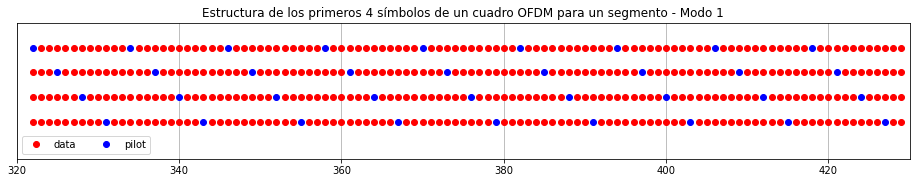

In [9]:
plt.figure(figsize=(16,2.5))
plt.title("Estructura de los primeros 4 símbolos de un cuadro OFDM para un segmento - Modo 1")
plt.plot(dataCarriers11[0:99], np.ones_like(dataCarriers11[0:99])*3, 'ro', label='data')
plt.plot(pilotCarriers11[0:9], np.ones_like(pilotCarriers11[0:9])*3, 'bo', label='pilot')
plt.plot(dataCarriers12[0:99], np.ones_like(dataCarriers12[0:99])*2, 'ro')
plt.plot(pilotCarriers12[0:9], np.ones_like(pilotCarriers12[0:9])*2, 'bo')
plt.plot(dataCarriers13[0:99], np.ones_like(dataCarriers13[0:99]), 'ro')
plt.plot(pilotCarriers13[0:9], np.ones_like(pilotCarriers13[0:9]), 'bo')
plt.plot(dataCarriers14[0:99], np.zeros_like(dataCarriers14[0:99]), 'ro')
plt.plot(pilotCarriers14[0:9], np.zeros_like(pilotCarriers14[0:9]), 'bo')
plt.legend(fontsize=10, ncol=2,loc=3)
plt.xlim((320,430))
plt.ylim((-1.5,4))
plt.yticks([])
plt.grid(True);

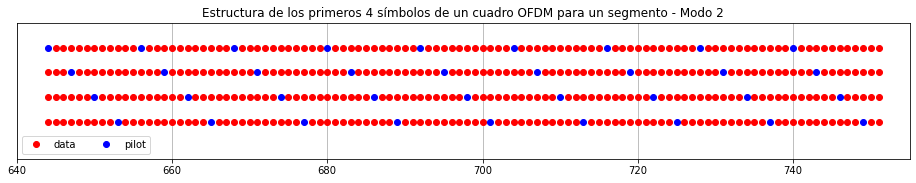

In [10]:
plt.figure(figsize=(16,2.5))
plt.title("Estructura de los primeros 4 símbolos de un cuadro OFDM para un segmento - Modo 2")
plt.plot(dataCarriers21[0:99], np.ones_like(dataCarriers21[0:99])*3, 'ro', label='data')
plt.plot(pilotCarriers21[0:9], np.ones_like(pilotCarriers21[0:9])*3, 'bo', label='pilot')
plt.plot(dataCarriers22[0:99], np.ones_like(dataCarriers22[0:99])*2, 'ro')
plt.plot(pilotCarriers22[0:9], np.ones_like(pilotCarriers22[0:9])*2, 'bo')
plt.plot(dataCarriers23[0:99], np.ones_like(dataCarriers23[0:99]), 'ro')
plt.plot(pilotCarriers23[0:9], np.ones_like(pilotCarriers23[0:9]), 'bo')
plt.plot(dataCarriers24[0:99], np.zeros_like(dataCarriers24[0:99]), 'ro')
plt.plot(pilotCarriers24[0:9], np.zeros_like(pilotCarriers24[0:9]), 'bo')
plt.legend(fontsize=10, ncol=2,loc=3)
plt.xlim((640,755))
plt.ylim((-1.5,4))
plt.yticks([])
plt.grid(True);

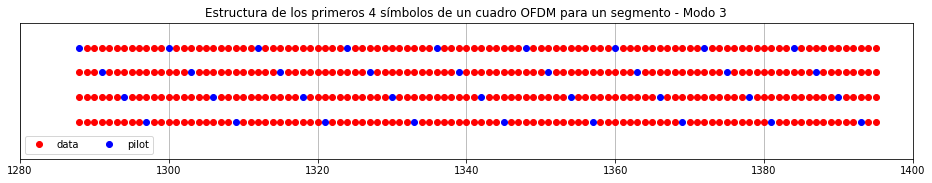

In [11]:
plt.figure(figsize=(16,2.5))
plt.title("Estructura de los primeros 4 símbolos de un cuadro OFDM para un segmento - Modo 3")
plt.plot(dataCarriers31[0:99], np.ones_like(dataCarriers31[0:99])*3, 'ro', label='data')
plt.plot(pilotCarriers31[0:9], np.ones_like(pilotCarriers31[0:9])*3, 'bo', label='pilot')
plt.plot(dataCarriers32[0:99], np.ones_like(dataCarriers32[0:99])*2, 'ro')
plt.plot(pilotCarriers32[0:9], np.ones_like(pilotCarriers32[0:9])*2, 'bo')
plt.plot(dataCarriers33[0:99], np.ones_like(dataCarriers33[0:99]), 'ro')
plt.plot(pilotCarriers33[0:9], np.ones_like(pilotCarriers33[0:9]), 'bo')
plt.plot(dataCarriers34[0:99], np.zeros_like(dataCarriers34[0:99]), 'ro')
plt.plot(pilotCarriers34[0:9], np.zeros_like(pilotCarriers34[0:9]), 'bo')
plt.legend(fontsize=10, ncol=2,loc=3)
plt.xlim((1280,1400))
plt.ylim((-1.5,4))
plt.yticks([])
plt.grid(True);

<img src=".\Estructura_Cuadro_OFDM.png">

Podemos ver la estructura de cada modo. 

La diferencia entre cada modo, es que en el modo 1 hay una menor cantidad de datos porque tenemos menor cantidad de portadoras por símbolo. En el modo 2, aumentan las portadoras con lo cual hay una mayor cantidad de datos respecto al modo 1 y para finalizar, en el modo 3 hay una mayor cantidad respecto del modo 2 y 3. 

En el gráfico esta limitado para ver la misma cantidad de portadoras y datos en los 3 modos. En el modo 1 podmeos verlo completo, no así en el modo 2 y 3. 

In [12]:
## Payload del símbolo OFDM
mu = 4 # bits por simbolo (i.e. 16-QAM)

# MODO 1
payloadBits_per_OFDM1 = len(dataCarriers11)*mu  # numero de bits de datos por símbolo OFDM

# MODO 2
payloadBits_per_OFDM2 = len(dataCarriers21)*mu  # numero de bits de datos por símbolo OFDM

# MODO 3
payloadBits_per_OFDM3 = len(dataCarriers31)*mu  # numero de bits de datos por símbolo OFDM

En esta parte lo que se hace es armar la carga útil de datos con 16QAM. 

dataCarriers son todas las portadoras que transportan datos. 

### Definimos el canal de comunicaciones inalaḿbrico entre el transmisor y el receptor

Empieza el armado del canal completo de comunicación inalámbrico. 

Primero vemos la respuesta al impulso de un canal de comunicaciones entre transmisor y receptor.

Podemos ver en el primer gráfico en micro-segundos la respuesta del canal.
Mientras que en el segundo gráfico podemos ver la transformada de fourier de la respuesta al canal. 

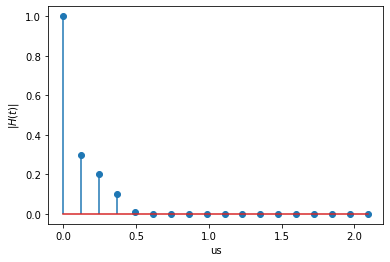

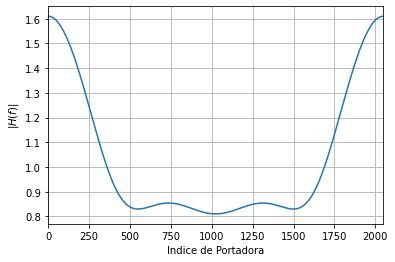

In [13]:
#Respuesta al impulso de un canal de comunicaciones
plt.figure()
channelResponse = np.array([1,0.3,0.2,0.1,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0])
plt.stem(t1_sinCP[0:len(channelResponse)],np.abs(channelResponse),use_line_collection=True)
plt.xlabel('us'); plt.ylabel('$|H(t)|$');
H_exact = np.fft.fft(channelResponse, L1)
plt.figure()
plt.plot(allCarriers1, abs(H_exact))
plt.xlabel('Indice de Portadora'); plt.ylabel('$|H(f)|$'); plt.grid(True); plt.xlim(0, L1-1)

SNRdb = 25  #Relación señal a ruido en dB en el receptor 

Ahora que tenemos los parámetros básicos de OFDM, continuaremos teniendo en mente el diagrama en bloques de un sistema OFDM.

Comenzaremos con una secuencia aleatoria de bits. Esto se hace como vimos en la presentación, para evitar largas series de ceros o unos, o cualquier otro patrón repetitivo, la señal de entrada debe transformarse en una secuencia cuasi-aleatoria. 

In [14]:
bits1 = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM1, ))
bits2 = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM2, ))
bits3 = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM3, ))
print ("N° de bits modo 1: ", len(bits1))
print ("N° de bits modo 2: ", len(bits2))
print ("N° de bits modo 3: ", len(bits3))
print ("Primeros 20 bits modo 1: ", bits1[:20])
print ("Primeros 20 bits modo 2: ", bits2[:20])
print ("Primeros 20 bits modo 3: ", bits3[:20])
print ("Media (deberían estar alrededor de 0.5): ", np.mean(bits1))

N° de bits modo 1:  5148
N° de bits modo 2:  10296
N° de bits modo 3:  20592
Primeros 20 bits modo 1:  [1 1 0 1 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0 1]
Primeros 20 bits modo 2:  [0 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 1 1]
Primeros 20 bits modo 3:  [1 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0]
Media (deberían estar alrededor de 0.5):  0.5052447552447552


Pasamos este flujo de bits por un conversor serie-paralelo, donde se agrupan los bits para el cuadro OFDM en grupos de mu bits (un grupo por cada subportadora).

In [15]:
def SP(bits,modo):
    if modo==1:
        return bits.reshape((len(dataCarriers11), mu))
    if modo==2:
        return bits.reshape((len(dataCarriers21), mu))
    if modo==3:
        return bits.reshape((len(dataCarriers31), mu))
bits_SP1 = SP(bits1,1)
bits_SP2 = SP(bits2,2)
bits_SP3 = SP(bits3,3)
print ("Primeros 5 grupos modo 1")
print (bits_SP1[:5,:])
print ("Primeros 5 grupos modo 2")
print (bits_SP2[:5,:])
print ("Primeros 5 grupos modo 3")
print (bits_SP3[:5,:])

Primeros 5 grupos modo 1
[[1 1 0 1]
 [1 1 0 0]
 [1 0 1 1]
 [0 1 0 0]
 [1 1 0 1]]
Primeros 5 grupos modo 2
[[0 0 0 1]
 [0 1 1 0]
 [1 1 0 1]
 [1 1 0 1]
 [0 0 1 1]]
Primeros 5 grupos modo 3
[[1 0 0 1]
 [0 1 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 1 0]]


Enviamos ahora los grupos de 4 bits al mapeador, el cual los convierte en símbolos de la constelación complejos de acuerdo a la tabla definida al comienzo del programa.

In [16]:
def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])
QAM1 = Mapping(bits_SP1)
QAM2 = Mapping(bits_SP2)
QAM3 = Mapping(bits_SP3)
print ("Primeros 5 simbolos QAM y bits, modo 1:")
print (bits_SP1[:5,:])
print ("Primeros 5 simbolos QAM y bits, modo 2:")
print (bits_SP2[:5,:])
print ("Primeros 5 simbolos QAM y bits, modo 3:")
print (bits_SP3[:5,:])


Primeros 5 simbolos QAM y bits, modo 1:
[[1 1 0 1]
 [1 1 0 0]
 [1 0 1 1]
 [0 1 0 0]
 [1 1 0 1]]
Primeros 5 simbolos QAM y bits, modo 2:
[[0 0 0 1]
 [0 1 1 0]
 [1 1 0 1]
 [1 1 0 1]
 [0 0 1 1]]
Primeros 5 simbolos QAM y bits, modo 3:
[[1 0 0 1]
 [0 1 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 1 0]]


El próximo paso, que no se muestra explícitamente en el diagrama, es la asignación de diferentes subportadoras con datos y pilotos. Para cada subportadora hemos definido si transporta datos o una piloto, de acuerdo a los arreglos denominados como dataCarriers y pilotCarriers. Ahora, para crear los datos generales de OFDM, necesitamos poner los datos y las pilotos en las portadoras OFDM.

Cantidad de portadoras OFDM en el dominio de la frecuencia, modo 1:  2048
Cantidad de portadoras OFDM en el dominio de la frecuencia, modo 2:  4096
Cantidad de portadoras OFDM en el dominio de la frecuencia, modo 3:  8192


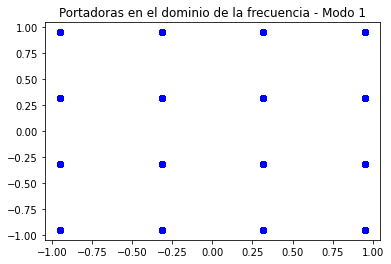

In [17]:
def OFDM_symbol(QAM_payload,i,modo):
    if modo==1:
        symbol = np.zeros(L1, dtype=complex) # Cero en todas las portadoras
        if i==0:
            symbol[pilotCarriers11] = pilotValue  # Cargo el valor del piloto siguiendo la secuencia 
            symbol[dataCarriers11] = QAM_payload  # Ubico los datos en las portadoras de dato
        if i==1:
            symbol[pilotCarriers12] = pilotValue  # Cargo el valor del piloto siguiendo la secuencia 
            symbol[dataCarriers12] = QAM_payload  # Ubico los datos en las portadoras de dato
        if i==2:
            symbol[pilotCarriers13] = pilotValue  # Cargo el valor del piloto siguiendo la secuencia 
            symbol[dataCarriers13] = QAM_payload  # Ubico los datos en las portadoras de dato
        if i==3:
            symbol[pilotCarriers14] = pilotValue  # Cargo el valor del piloto siguiendo la secuencia 
            symbol[dataCarriers14] = QAM_payload  # Ubico los datos en las portadoras de dato
        return symbol
    if modo==2:
        symbol = np.zeros(L2, dtype=complex) # Cero en todas las portadoras
        if i==0:
            symbol[pilotCarriers21] = pilotValue  # Cargo el valor del piloto siguiendo la secuencia 
            symbol[dataCarriers21] = QAM_payload  # Ubico los datos en las portadoras de dato
        if i==1:
            symbol[pilotCarriers22] = pilotValue  # Cargo el valor del piloto siguiendo la secuencia 
            symbol[dataCarriers22] = QAM_payload  # Ubico los datos en las portadoras de dato
        if i==2:
            symbol[pilotCarriers23] = pilotValue  # Cargo el valor del piloto siguiendo la secuencia 
            symbol[dataCarriers23] = QAM_payload  # Ubico los datos en las portadoras de dato
        if i==3:
            symbol[pilotCarriers24] = pilotValue  # Cargo el valor del piloto siguiendo la secuencia 
            symbol[dataCarriers24] = QAM_payload  # Ubico los datos en las portadoras de dato
        return symbol
    if modo==3:
        symbol = np.zeros(L3, dtype=complex) # Cero en todas las portadoras
        if i==0:
            symbol[pilotCarriers31] = pilotValue  # Cargo el valor del piloto siguiendo la secuencia 
            symbol[dataCarriers31] = QAM_payload  # Ubico los datos en las portadoras de dato
        if i==1:
            symbol[pilotCarriers32] = pilotValue  # Cargo el valor del piloto siguiendo la secuencia 
            symbol[dataCarriers32] = QAM_payload  # Ubico los datos en las portadoras de dato
        if i==2:
            symbol[pilotCarriers33] = pilotValue  # Cargo el valor del piloto siguiendo la secuencia 
            symbol[dataCarriers33] = QAM_payload  # Ubico los datos en las portadoras de dato
        if i==3:
            symbol[pilotCarriers34] = pilotValue  # Cargo el valor del piloto siguiendo la secuencia 
            symbol[dataCarriers34] = QAM_payload  # Ubico los datos en las portadoras de dato
        return symbol

OFDM_data1 = OFDM_symbol(QAM1,0,1)
OFDM_data2 = OFDM_symbol(QAM2,0,2)
OFDM_data3 = OFDM_symbol(QAM3,0,3)
print ("Cantidad de portadoras OFDM en el dominio de la frecuencia, modo 1: ", len(OFDM_data1))
print ("Cantidad de portadoras OFDM en el dominio de la frecuencia, modo 2: ", len(OFDM_data2))
print ("Cantidad de portadoras OFDM en el dominio de la frecuencia, modo 3: ", len(OFDM_data3))
plt.figure("Portadoras en el dominio de la frecuencia - Modo 1")
plt.title("Portadoras en el dominio de la frecuencia - Modo 1")
plt.plot(OFDM_data1.real[dataCarriers11],OFDM_data1.imag[dataCarriers11],'bo');

Ahora, las portadoras OFDM contenidas en OFDM_data pueden transformarse al dominio del tiempo mediante la operación IFFT.

Cantidad de muestras OFDM en el dominio del tiempo antes de agregar el prefijo cíclico, modo 1:  2048
Cantidad de muestras OFDM en el dominio del tiempo antes de agregar el prefijo cíclico, modo 2:  4096
Cantidad de muestras OFDM en el dominio del tiempo antes de agregar el prefijo cíclico, modo 3:  8192
Duración del símbolo activo 252.00us, modo 1.
Duración del símbolo activo 504.00us, modo 2.
Duración del símbolo activo 1008.00us, modo 3.


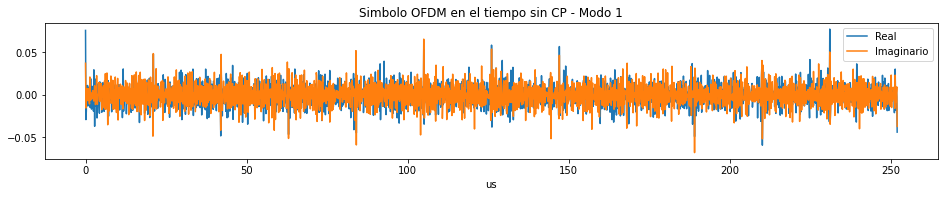

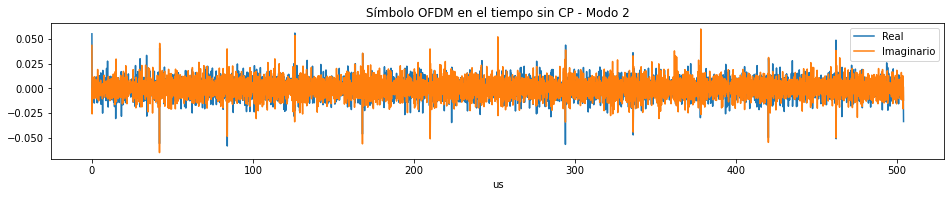

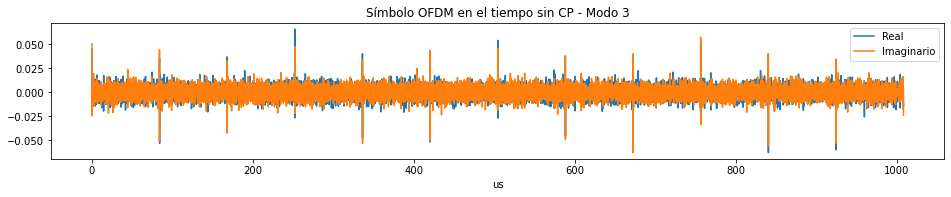

In [18]:
def IFFT(OFDM_data):
    return np.fft.ifft(OFDM_data)
OFDM_time1 = IFFT(OFDM_data1)
OFDM_time2 = IFFT(OFDM_data2)
OFDM_time3 = IFFT(OFDM_data3)
print ("Cantidad de muestras OFDM en el dominio del tiempo antes de agregar el prefijo cíclico, modo 1: ", len(OFDM_time1))
print ("Cantidad de muestras OFDM en el dominio del tiempo antes de agregar el prefijo cíclico, modo 2: ", len(OFDM_time2))
print ("Cantidad de muestras OFDM en el dominio del tiempo antes de agregar el prefijo cíclico, modo 3: ", len(OFDM_time3))
plt.figure(figsize=(16,2.5))
plt.title("Simbolo OFDM en el tiempo sin CP - Modo 1")
plt.xlabel("us")
plt.plot(t1_sinCP,OFDM_time1.real,label="Real")
plt.plot(t1_sinCP,OFDM_time1.imag,label="Imaginario")
plt.legend(fontsize=10)
print("Duración del símbolo activo {0:.2f}us, modo 1.".format(t1_sinCP[-1]))
plt.figure(figsize=(16,2.5))
plt.title("Símbolo OFDM en el tiempo sin CP - Modo 2")
plt.xlabel("us")
plt.plot(t2_sinCP,OFDM_time2.real,label="Real")
plt.plot(t2_sinCP,OFDM_time2.imag,label="Imaginario")
plt.legend(fontsize=10)
print("Duración del símbolo activo {0:.2f}us, modo 2.".format(t2_sinCP[-1]))
plt.figure(figsize=(16,2.5))
plt.title("Símbolo OFDM en el tiempo sin CP - Modo 3")
plt.xlabel("us")
plt.plot(t3_sinCP,OFDM_time3.real,label="Real")
plt.plot(t3_sinCP,OFDM_time3.imag,label="Imaginario")
plt.legend(fontsize=10)
print("Duración del símbolo activo {0:.2f}us, modo 3.".format(t3_sinCP[-1]))

Luego, agregamos un prefijo cíclico, o tiempo de guarda, a cada símbolo. Esta operación concatena una copia de las últimas CP muestras de la señal OFDM en el dominio del tiempo, al comienzo del símbolo. El prefijo cíclico cumple dos funciones:

1) Aísla diferentes bloques OFDM entre sí cuando el canal de comunicaciones contiene múltiples trayectorias, es decir, es selectivo en frecuencia.

2) Convierte la convolución lineal con el canal en uno circular. Solamente mediante la convolución circular, podemos usar la ecualización por la que OFDM es tan utilizado.

En este caso, del simbolo total, el prefijo ciclico es 63us y el tiempo de simbolo activo es 252us. Esto representa un $\Delta=\frac{1}{4}$.

Número de muestras OFDM en el dominio del tiempo con prefijo cíclico, modo 1:  2560
Número de muestras OFDM en el dominio del tiempo con prefijo cíclico, modo 2:  5120
Número de muestras OFDM en el dominio del tiempo con prefijo cíclico, modo 3:  10240
Duración del símbolo con el prefijo cíclico 315.00us, modo 1.
Duración del símbolo con el prefijo cíclico 630.00us, modo 2.
Duración del símbolo con el prefijo cíclico 1260.00us, modo 3.


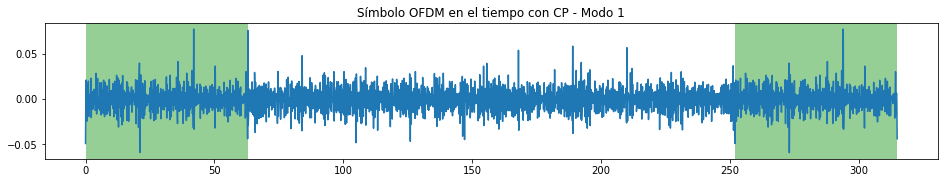

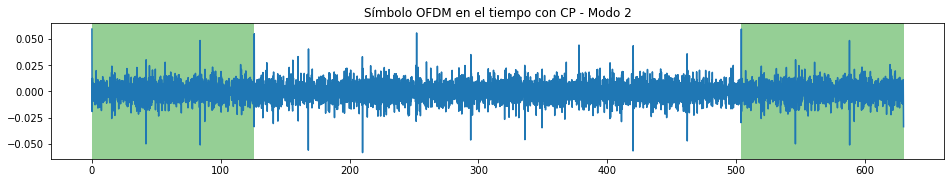

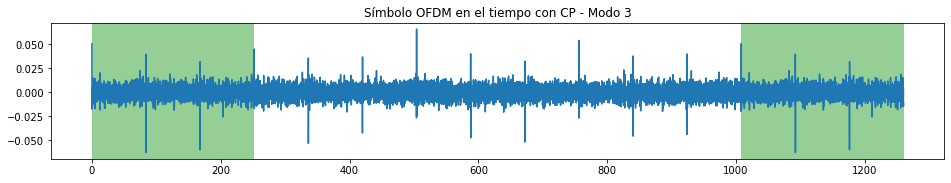

In [19]:
def addCP(OFDM_time,modo):
    if modo==1:
        cp = OFDM_time[-CP1:] #  Toma las últimas muestras CP
        return np.hstack([cp, OFDM_time])  #  Y las agrega al inicio del símbolo
    if modo==2:
        cp = OFDM_time[-CP2:] #  Toma las últimas muestras CP
        return np.hstack([cp, OFDM_time])  #  Y las agrega al inicio del símbolo
    if modo==3:
        cp = OFDM_time[-CP3:] #  Toma las últimas muestras CP
        return np.hstack([cp, OFDM_time])  #  Y las agrega al inicio del símbolo

OFDM_withCP1 = addCP(OFDM_time1,1)
OFDM_withCP2 = addCP(OFDM_time2,2)
OFDM_withCP3 = addCP(OFDM_time3,3)

#Número de muestras luego de CP=(5/4)*K
print ("Número de muestras OFDM en el dominio del tiempo con prefijo cíclico, modo 1: ", len(OFDM_withCP1))
print ("Número de muestras OFDM en el dominio del tiempo con prefijo cíclico, modo 2: ", len(OFDM_withCP2))
print ("Número de muestras OFDM en el dominio del tiempo con prefijo cíclico, modo 3: ", len(OFDM_withCP3))

plt.figure(figsize=(16,2.5))
plt.title("Símbolo OFDM en el tiempo con CP - Modo 1")
plt.plot(t1_conCP,OFDM_withCP1.real);
plt.axvspan(t1_conCP[0],t1_conCP[L1//4], facecolor='#2ca02c', alpha=0.5);
plt.axvspan(t1_conCP[len(t1_conCP)-L1//4],t1_conCP[-1], facecolor='#2ca02c', alpha=0.5);
print("Duración del símbolo con el prefijo cíclico {0:.2f}us, modo 1.".format(t1_conCP[-1]))

plt.figure(figsize=(16,2.5))
plt.title("Símbolo OFDM en el tiempo con CP - Modo 2")
plt.plot(t2_conCP,OFDM_withCP2.real);
plt.axvspan(t2_conCP[0],t2_conCP[L2//4], facecolor='#2ca02c', alpha=0.5);
plt.axvspan(t2_conCP[len(t2_conCP)-L2//4],t2_conCP[-1], facecolor='#2ca02c', alpha=0.5);
print("Duración del símbolo con el prefijo cíclico {0:.2f}us, modo 2.".format(t2_conCP[-1]))

plt.figure(figsize=(16,2.5))
plt.title("Símbolo OFDM en el tiempo con CP - Modo 3")
plt.plot(t3_conCP,OFDM_withCP3.real);
plt.axvspan(t3_conCP[0],t3_conCP[L3//4], facecolor='#2ca02c', alpha=0.5);
plt.axvspan(t3_conCP[len(t3_conCP)-L3//4],t3_conCP[-1], facecolor='#2ca02c', alpha=0.5);
print("Duración del símbolo con el prefijo cíclico {0:.2f}us, modo 3.".format(t3_conCP[-1]))

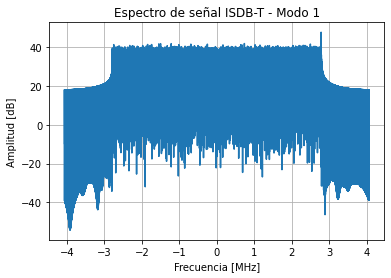

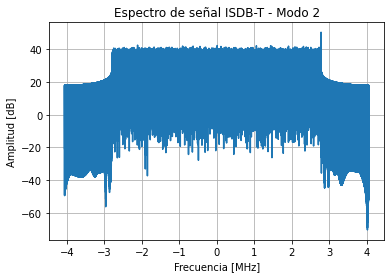

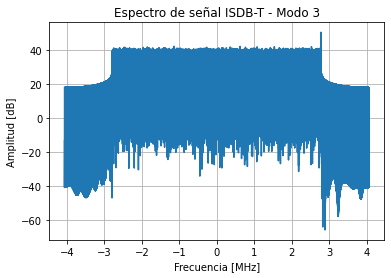

In [20]:
N_of_sym=204
frame1=np.empty(0)
frame2=np.empty(0)
frame3=np.empty(0)
for sym in range(N_of_sym//4):
    for i in range(4):
        # MODO 1
        bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM1, ))
        bits_SP = SP(bits,1)
        QAM = Mapping(bits_SP)
        OFDM_data = OFDM_symbol(QAM,i,1)
        OFDM_time = IFFT(OFDM_data)
        OFDM_withCP = addCP(OFDM_time,1)
        frame1=np.append(frame1,OFDM_withCP,axis=0)
        # MODO 2
        bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM2, ))
        bits_SP = SP(bits,2)
        QAM = Mapping(bits_SP)
        OFDM_data = OFDM_symbol(QAM,i,2)
        OFDM_time = IFFT(OFDM_data)
        OFDM_withCP = addCP(OFDM_time,2)
        frame2=np.append(frame2,OFDM_withCP,axis=0)
        # MODO 3
        bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM3, ))
        bits_SP = SP(bits,3)
        QAM = Mapping(bits_SP)
        OFDM_data = OFDM_symbol(QAM,i,3)
        OFDM_time = IFFT(OFDM_data)
        OFDM_withCP = addCP(OFDM_time,3)
        frame3=np.append(frame3,OFDM_withCP,axis=0)

plt.figure()
fcia=np.linspace(-fs/2,fs/2,len(frame1))
plt.plot(fcia,20*np.log10(np.abs(np.fft.fft(frame1))))
plt.title("Espectro de señal ISDB-T - Modo 1")
plt.xlabel("Frecuencia [MHz]")
plt.ylabel("Amplitud [dB]")
plt.grid(True)

plt.figure()
fcia=np.linspace(-fs/2,fs/2,len(frame2))
plt.plot(fcia,20*np.log10(np.abs(np.fft.fft(frame2))))
plt.title("Espectro de señal ISDB-T - Modo 2")
plt.xlabel("Frecuencia [MHz]")
plt.ylabel("Amplitud [dB]")
plt.grid(True)

plt.figure()
fcia=np.linspace(-fs/2,fs/2,len(frame3))
plt.plot(fcia,20*np.log10(np.abs(np.fft.fft(frame3))))
plt.title("Espectro de señal ISDB-T - Modo 3")
plt.xlabel("Frecuencia [MHz]")
plt.ylabel("Amplitud [dB]")
plt.grid(True)

# A estos frame les voy a medir la PAR y el CCDF

### Estimo el canal y obtengo los bits originales del modo 1
Ahora, la señal se manda a la antena, y luego se envía a través del canal de comunicaciones al receptor. Modelamos este canal como un canal estático multi-trayectorias con respuesta al impulso denominada channelResponse. Por lo tanto, la señal en el extremo receptor es la convolución entre la señal transmitida con la respuesta en frecuencia del canal. Además, agregamos ruido a la señal de acuerdo con el valor de SNR del canal.

RX Signal power: 0.0003. Noise power: 0.0000


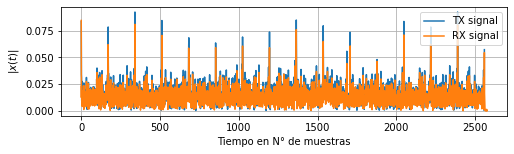

In [21]:
def channel(signal):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)  # Calcula la potencia de ruido en base al SNR
    print ("RX Signal power: %.4f. Noise power: %.4f" % (signal_power, sigma2))
    # Genero el ruido a partir de la varianza obtenida
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved + noise
OFDM_TX = OFDM_withCP1
OFDM_RX = channel(OFDM_TX)
plt.figure(figsize=(8,2))
plt.plot(abs(OFDM_TX), label='TX signal')
plt.plot(abs(OFDM_RX), label='RX signal')
plt.legend(fontsize=10)
plt.xlabel('Tiempo en N° de muestras'); plt.ylabel('$|x(t)|$');
plt.grid(True);

La conclusión que podemos sacar acá es que al recibir la señal la recibimos un poco más atenuada que cuando se trasmitió.

Ahora, en el receptor, el prefijo cíclico es eliminado de la señal y una ventana de K muestras se extrae de la señal recibida.

In [22]:
def removeCP(signal,modo):
    if modo==1:
        return signal[CP1:(CP1+L1)]
    if modo==2:
        return signal[CP2:(CP2+L2)]
    if modo==3:
        return signal[CP3:(CP3+L3)]
OFDM_RX_noCP1 = removeCP(OFDM_RX,1)

Luego, la señal se transforma nuevamente al dominio de la frecuencia, para tener el valor recibido en cada subportadora disponible.

In [23]:
def FFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)
OFDM_demod = FFT(OFDM_RX_noCP1)

Como siguiente paso, el canal inalámbrico necesita ser estimado. Con fines ilustrativos, recurrimos a una simple estimación del canal de "zero-forcing" seguida de una interpolación. El principio de estimación del canales el siguiente:

La señal de transmisión contiene valores piloto en ciertas portadoras piloto. El receptor conoce estos valores piloto y su posición en el dominio de la frecuencia (el índice de portadora piloto). A partir de la información recibida en las subportadoras piloto, el receptor puede estimar el efecto del canal inalámbrico en esta subportadora (porque sabe qué se transmitió y qué se recibió). Por lo tanto, el receptor obtiene información sobre el canal inalámbrico a partir de las portadoras piloto. Sin embargo, quiere saber qué sucedió en las portadoras de datos. Para lograr esto, interpola los valores del canal entre las portadoras piloto para obtener una estimación del canal en las portadoras de datos.

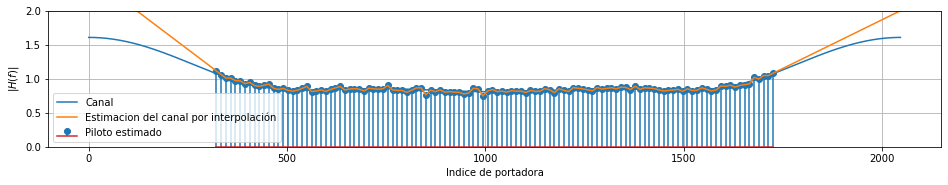

In [24]:
def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers11]  # Extraigo el piloto de la senal recibida
    Hest_at_pilots = pilots / pilotValue # Divido por el valor de los pilotos transmitidos
    # Hago una interpolacion entre las portadoras piloto para obtener una estimación del canal sobre las portadoras de datos
    # Interpolamos el valor absoluto y la fase por separado
    Hest_abs = interpolate.interp1d(pilotCarriers11, abs(Hest_at_pilots), kind='linear',fill_value="extrapolate")(allCarriers1)
    Hest_phase = interpolate.interp1d(pilotCarriers11, np.angle(Hest_at_pilots), kind='linear',fill_value="extrapolate")(allCarriers1)
    Hest = Hest_abs * np.exp(1j*Hest_phase)
    
    plt.figure(figsize=(16,2.5))
    plt.plot(allCarriers1, abs(H_exact), label='Canal')
    plt.stem(pilotCarriers11, abs(Hest_at_pilots), label='Piloto estimado',use_line_collection=True)
    plt.plot(allCarriers1, abs(Hest), label='Estimacion del canal por interpolación')
    plt.grid(True)
    plt.xlabel('Indice de portadora')
    plt.ylabel('$|H(f)|$')
    plt.legend(fontsize=10)
    plt.ylim(0,2)
    return Hest
Hest = channelEstimate(OFDM_demod)

Ahora que el canal se ha estimado en todas las portadoras, podemos usar esta información del canal en el ecualizador. Para cada subportadora, la influencia del canal se elimina de manera que podemos obtener los símbolos de la constelación correctamente (sólo con ruido).

In [25]:
def equalize(OFDM_demod, Hest):
    return OFDM_demod / Hest
equalized_Hest = equalize(OFDM_demod, Hest)

El próximo paso, que no se muestra explícitamente en el diagrama, es extraer las portadoras de datos a partir de los símbolos ecualizados. Dejamos de lado las portadoras piloto, que no aportan información, pero que han sido utilizadas previamente para la estimación del canal.

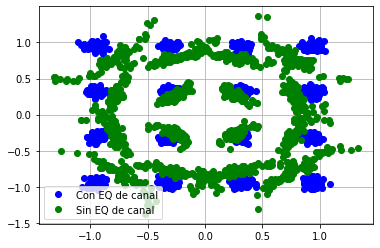

In [26]:
def get_payload(equalized):
    return equalized[dataCarriers11]
QAM_est = get_payload(equalized_Hest)
QAM_sin_est = get_payload(OFDM_demod)

plt.plot(QAM_est.real, QAM_est.imag, 'bo',label="Con EQ de canal");
plt.plot(QAM_sin_est.real, QAM_sin_est.imag, 'go',label="Sin EQ de canal");
plt.grid(True);
plt.legend(fontsize=10);

Podemos ver la importancia de ecualizar el canal, porque al hacerlo podemos ver la constelación correctamente. De no hacerlo como podemos observar no seria posible recuperar la constelación de manera correcta.

Ahora que recuperamos la constelación, necesitamos enviar los valores complejos al Demapper, para transformar los puntos de la constelación a los grupos de bits. Para hacer esto, comparamos cada punto de la constelación con cada punto de la constelación original y elegimos el más cercano al punto recibido. Luego, retornamos el grupo de bits que corresponde a este punto.

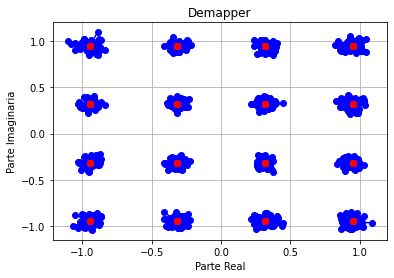

In [27]:
def Demapping(QAM):
    # Arreglo de puntos posibles de la constelación
    constellation = np.array([x for x in demapping_table.keys()])
    
    # Calculamos la distancia de cada punto recibido a cada punto posible de la constelación
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))
    
    # Para cada elemento en QAM, elegimos el punto de la constelación más cercano
    const_index = dists.argmin(axis=1)
    
    # Recuperamos el punto de constelación real
    hardDecision = constellation[const_index]
    
    # Transforma el punto de la constelación en grupos de bits
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision

PS_est, hardDecision = Demapping(QAM_est)
for qam, hard in zip(QAM_est, hardDecision):
    plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o');
    plt.plot(hardDecision.real, hardDecision.imag, 'ro');
plt.grid(True); plt.xlabel('Parte Real');
plt.ylabel('Parte Imaginaria');
plt.title('Demapper');

En el diagrama anterior, los puntos azules son los puntos QAM recibidos, mientras que los puntos rojos son los puntos de la constelación posibles más cercanos, y los grupos de bits correspondientes a estos puntos rojos son retornados.

Finalmente, los grupos de bits necesitan ser convertidos a un flujo de bits en serie mediante un conversor paralelo-serie.

In [28]:
def PS(bits):
    return bits.reshape((-1,))
bits_est = PS(PS_est)

Ahora que tenemos todos los bits decodificados, calculamos el Bit Error Rate (BER)

In [29]:
print ("BER obtenido:{0:.10f}".format(np.sum(abs(bits1-bits_est))/len(bits1))) 

BER obtenido:0.0000000000


Al obtener un BER de 0 significa que la probabilidad de tener un bit erroneo es mínima. 

## Medidas de Calidad

###  PAR o PAPR (Peak Average Power Ratio)

Es la relacion entre la potencia pico y la potencia media. Es un parametro que caracteriza la naturaleza de la señal. Se tiene en cuenta tanto para el diseño de los amplificadores como para la medición de la señal. En el caso de los amplificadores, estos deben tener una zona lineal lo suficientemente amplia para no distorsionar los picos de señal. Para el caso de la medicion, el detector se selecciona en el intrumento (analizador de espectro). 

La PAR se define como:

$PAR = \frac{MAX[x(t).x(t)*]}{E[x(t).x(t)*]}$

La PAR ocurre cuando en un sistema multiportador las diferentes subportadoras están desfasadas entre sí. En cada instante son diferentes entre sí en diferentes valores de fase. Cuando todos los puntos alcanzan el valor máximo simultáneamente, la envolvente de la señal de salida se dispara repentinamente, lo que provoca un "pico".

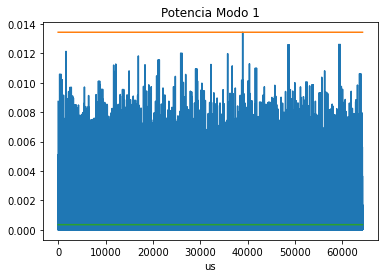

La relacion entre la potencia pico y la potencia media (modo 1) es 15.75 dB.


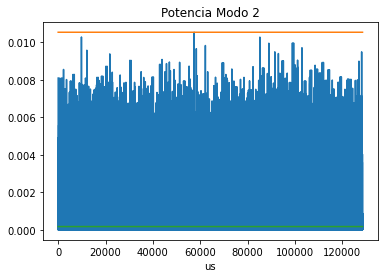

La relacion entre la potencia pico y la potencia media (modo 2) es 17.71 dB.


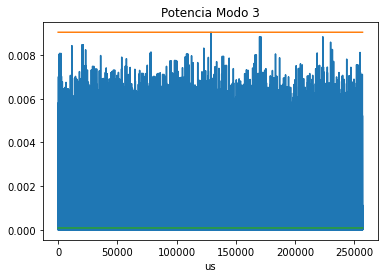

La relacion entre la potencia pico y la potencia media (modo 3) es 20.06 dB.


In [30]:
t1_frame=np.linspace(0,len(frame1)*ts,len(frame1))
t2_frame=np.linspace(0,len(frame2)*ts,len(frame2))
t3_frame=np.linspace(0,len(frame3)*ts,len(frame3))

#MODO 1
potencia_frame1=frame1*np.conj(frame1)
plt.figure()
plt.plot(t1_frame,(potencia_frame1).real,label='instantanea')
plt.plot(t1_frame,np.ones(len(frame1))*np.max(potencia_frame1).real,label='pico')
plt.plot(t1_frame,np.ones(len(frame1))*np.mean(potencia_frame1).real,label='media')
plt.title("Potencia Modo 1")
plt.xlabel("us")
plt.show()

PAR1=(np.max(potencia_frame1)/np.mean(potencia_frame1)).real
print("La relacion entre la potencia pico y la potencia media (modo 1) es %.2f dB."%(10*np.log10(PAR1)))

#MODO 2
potencia_frame2=frame2*np.conj(frame2)
plt.figure()
plt.plot(t2_frame,(potencia_frame2).real,label='instantanea')
plt.plot(t2_frame,np.ones(len(frame2))*np.max(potencia_frame2).real,label='pico')
plt.plot(t2_frame,np.ones(len(frame2))*np.mean(potencia_frame2).real,label='media')
plt.title("Potencia Modo 2")
plt.xlabel("us")
plt.show()

PAR2=(np.max(potencia_frame2)/np.mean(potencia_frame2)).real
print("La relacion entre la potencia pico y la potencia media (modo 2) es %.2f dB."%(10*np.log10(PAR2)))

#MODO 3
potencia_frame3=frame3*np.conj(frame3)
plt.figure()
plt.plot(t3_frame,(potencia_frame3).real,label='instantanea')
plt.plot(t3_frame,np.ones(len(frame3))*np.max(potencia_frame3).real,label='pico')
plt.plot(t3_frame,np.ones(len(frame3))*np.mean(potencia_frame3).real,label='media')
plt.title("Potencia Modo 3")
plt.xlabel("us")
plt.show()

PAR3=(np.max(potencia_frame3)/np.mean(potencia_frame3)).real
print("La relacion entre la potencia pico y la potencia media (modo 3) es %.2f dB."%(10*np.log10(PAR3)))

En los gráficos anteriores podemos observar que la PAR crece con el número de portadoras OFDM.

### CCDF (Power Complementary Cumulative Distribution Function)

La curva CCDF muestra cuánto tiempo pasa la señal en o por encima del nivel de potencia promedio de la señal medida (en dB), o de manera equivalente, la probabilidad de que la potencia de la señal esté por encima del nivel de potencia promedio.

Desafortunadamente, las señales similares al ruido (Noise-Like Signals) son difíciles de cuantificar debido a su aleatoriedad e inconsistencias inherentes. Para extraer información útil de este tipo de señales necesitamos una descripción estadística de los niveles de potencia en esta señal y la CCDF proporciona exactamente eso.

La curva CCDF se genera calculando primero la función de densidad de probabilidad (PDF) mediante un histograma de la señal medida. La suma acumulada de todos los puntos de esta PDF (o la integral en el caso de una señal continua) será la CDF. Entonces, para obtener el complemento hacemos 1-CDF. Esto estima la probabilidad de que una muestra tenga un valor de potencia instantánea mayor que la potencia máxima.

La medición de CCDF solo se muestra para valores de potencia mayores que la potencia promedio de las muestras del histograma.


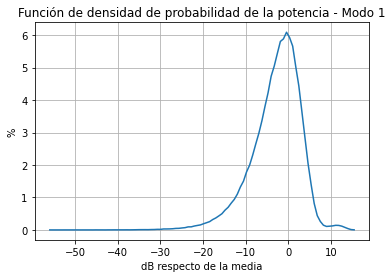

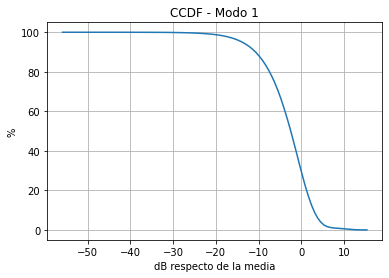

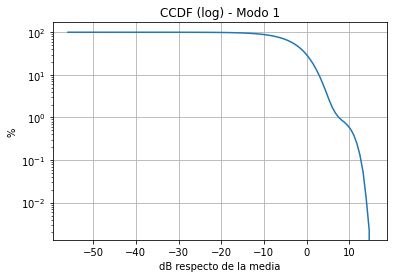

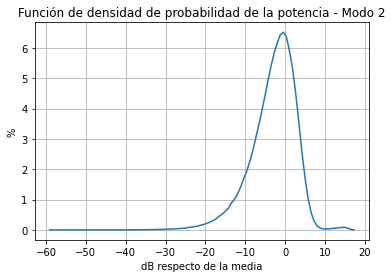

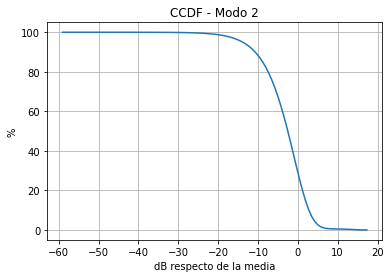

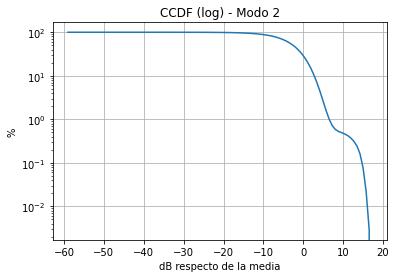

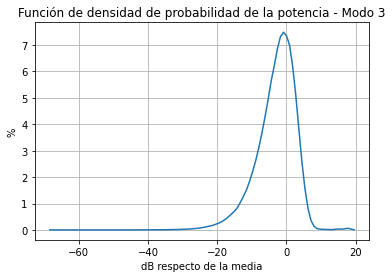

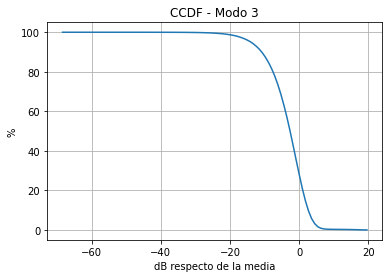

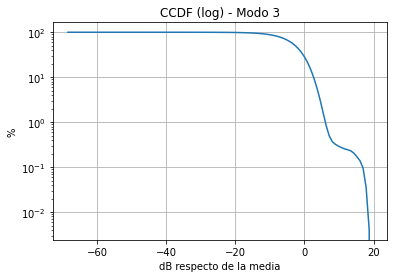

In [31]:
def CCDF(potencia):
    h = np.histogram(potencia, 100)
    CCDF=1-h[0].cumsum()
    return (h[1][:-1]+h[1][1:])/2, (CCDF/len(potencia)+1)*100

def CCDFdB(potencia):
    dB=10*np.log10(potencia.real)-10*np.log10(np.mean(potencia.real))  # 0dB sera respecto de la potencia media   
    h = np.histogram(dB, 100)
    H = np.cumsum(h[0])/len(potencia)
    CH=1-H
    return (h[1][:-1]+h[1][1:])/2,CH*100

dB1=10*np.log10(potencia_frame1.real)-10*np.log10(np.mean(potencia_frame1.real))  # 0dB sera respecto de la potencia media   
dB2=10*np.log10(potencia_frame2.real)-10*np.log10(np.mean(potencia_frame2.real))  # 0dB sera respecto de la potencia media   
dB3=10*np.log10(potencia_frame3.real)-10*np.log10(np.mean(potencia_frame3.real))  # 0dB sera respecto de la potencia media   

h1 = np.histogram(dB1, 100)
h2 = np.histogram(dB2, 100)
h3 = np.histogram(dB3, 100)

# MODO 1 
plt.figure()
plt.plot((h1[1][:-1]+h1[1][1:])/2,(h1[0]/len(dB1))*100)
plt.title("Función de densidad de probabilidad de la potencia - Modo 1")
plt.xlabel("dB respecto de la media")
plt.ylabel("%")
plt.grid(True)

plt.figure()
x,y=CCDFdB((potencia_frame1.real))
plt.plot(x,y)
plt.title("CCDF - Modo 1")
plt.xlabel("dB respecto de la media")
plt.ylabel("%")
plt.grid(True)

fig, ax = plt.subplots()

ax.semilogy(x,y)
ax.grid()
ax.set_title("CCDF (log) - Modo 1")
ax.set_xlabel("dB respecto de la media")
ax.set_ylabel("%")
plt.show()

# MODO 2
plt.figure()
plt.plot((h2[1][:-1]+h2[1][1:])/2,(h2[0]/len(dB2))*100)
plt.title("Función de densidad de probabilidad de la potencia - Modo 2")
plt.xlabel("dB respecto de la media")
plt.ylabel("%")
plt.grid(True)

plt.figure()
x,y=CCDFdB((potencia_frame2.real))
plt.plot(x,y)
plt.title("CCDF - Modo 2")
plt.xlabel("dB respecto de la media")
plt.ylabel("%")
plt.grid(True)

fig, ax = plt.subplots()

ax.semilogy(x,y)
ax.grid()
ax.set_title("CCDF (log) - Modo 2")
ax.set_xlabel("dB respecto de la media")
ax.set_ylabel("%")
plt.show()

# MODO 3
plt.figure()
plt.plot((h3[1][:-1]+h3[1][1:])/2,(h3[0]/len(dB3))*100)
plt.title("Función de densidad de probabilidad de la potencia - Modo 3")
plt.xlabel("dB respecto de la media")
plt.ylabel("%")
plt.grid(True)

plt.figure()
x,y=CCDFdB((potencia_frame3.real))
plt.plot(x,y)
plt.title("CCDF - Modo 3")
plt.xlabel("dB respecto de la media")
plt.ylabel("%")
plt.grid(True)

fig, ax = plt.subplots()

ax.semilogy(x,y)
ax.grid()
ax.set_title("CCDF (log) - Modo 3")
ax.set_xlabel("dB respecto de la media")
ax.set_ylabel("%")
plt.show()



## Modulation Error Ratio (MER)

La tasa de error de modulación o MER es una medida utilizada para cuantificar el rendimiento de un transmisor o receptor de radio digital (o TV digital) en un sistema de comunicaciones que utiliza modulación digital (como QAM ). Una señal enviada por un transmisor ideal o recibida por un receptor tendría todos los puntos de constelación precisamente en las ubicaciones ideales, sin embargo, varias imperfecciones en la implementación (como ruido , baja tasa de rechazo de imagen , ruido de fase , supresión de portadora , distorsión )., etc.) o la ruta de la señal hacen que los puntos reales de la constelación se desvíen de las ubicaciones ideales.

El MER del transmisor se puede medir con un equipo especializado, que demodula la señal recibida de manera similar a como lo hace un demodulador de radio real. La señal demodulada y detectada se puede usar como una estimación razonablemente confiable para la señal transmitida ideal en el cálculo de MER.



<img src=".\Pav.png" width="500" height="250">

<img src=".\Mer.png" width="500" height="250">

In [32]:
Pav = -2.0412 #dB Pav of QAM-16 = 10*log10(5/8)
e_sq= ((hard.real)**2 + (hard.imag)**2) # error squared
e_sq_av= np.sum(e_sq)/2048 # 2048 porque estoy simulando modo 1 y son la cantidad de numeros de simbolos
mer_dB= Pav - 10 * np.log10(e_sq_av)
print("Mer: {0:.3f} dB".format(mer_dB))

Mer: 31.072 dB


Al calcular MER para QAM-16, se usa Pav = 5/8. 
Los valores I y Q de QAM-16 provienen del la constelacion calculada anteriormente. 

Conclusión: Podemos observar que cuanto más difusa es la nube de constelaciones, menor es el MER.